# Intersections
## Notebook 8

## Gabriel del Valle
## 10/25/24
## NYC DATA SCIENCE ACADEMY

### For any questions about this project or to request full map videos or datasets, please feel free to reach out on Linkedin: 

   www.linkedin.com/in/gabriel-del-valle-147616152


In this notebook I've revisited the Animated NYC Congestion Zone Traffic Map Analysis to portray the to street and from street relationships in the data and the directional exchanges of volume they represent. In order to portray relationships in the Automated Traffic Counts Dataset which are not given a distinct geographic coordinate, I located exchanges of volume on the map using intersections, which could be corresponded to geometric intersections between streets in the base_map.geojson dataset. 

My success at identifying geometric intersections and using them to locate directional volume flows on the map allowed me to produce the animations in the next notebook, 09_Directional_Traffic_Flow_Map.

### sorted_intersection_dates:
The core acomplishment of this notebook that is crucial in the next notebook is the creation of the dataframe sorted_intersection_dates, which stores all the information which is needed to track the known exchanges of volumes between streets in the OTMD dataset, and correspond these to intersections on the map:

- datetime
- to_vol 	
- from_vol 	
- total_vol  (really net_volume)	
- street1 	
- SegmentID1 	
- s1_dir 	
- s1_from 	
- s1_to 	
- street2 	
- SegmentID2 	
- s2_dir 	
- s2_from
- s2_to 	
- marker  (coordinates)
- intersection_id 	
- gain_street 	
- lose_street



## Functions:


### generate_markers( )

    Given a street geometry and a marker spacing generates markers for along the street geometry, with the number of markers determined by the street's vertical length.
    
    
### plot_street_markers( )

    Given a street name and a marker spacing, calls generate_markers() to generate markers for each geometry value for the given street and print the results.
    
    
### find_intersections2( )

    Find all unique instances where a recorded exchange of volume between 2 streets in OTMD corresponds to a geometric intersection between two streets in basemap.geojson. Recorded the streets and the intersection coordinates.
    
    
### assign_traffic_flow( )

    Process the output of find_intersections2 to identify the direction of traffic flow between intersections using toSt and fromSt values, and assign the labels lose_street or gain_street respectively. Output a new dataframe with gain_street and lose_street columns added to the input dataframe.
    
    
### intersection_map( )

    For a given datetime, plots intersection markers where there is a recorded exchange of volume beteween two streets at the given datetetime.
    
    
    
### create_intersection_index( )

    Identifies and creates an index of all geometric intersections between streets in basemap.geojson. Stores marker coordinates, street1, and street2


    


In [1]:
from shapely.wkt import loads
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import MultiLineString, LineString
import re
import os
import cv2
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap

In [58]:
import numpy as np

In [2]:
czone_October = pd.read_csv("czone_October.csv")

In [3]:
czone_October.columns

Index(['RequestID', 'Boro', 'year', 'month', 'day', 'hour', 'minute', 'Vol',
       'SegmentID', 'WktGeom', 'street', 'fromSt', 'toSt', 'Direction'],
      dtype='object')

In [4]:
base_map = gpd.read_file('base_map.geojson')

In [5]:
base_map.columns

Index(['rw_type', 'l_low_hn', 'pre_direct', 'st_width', 'r_zip', 'r_low_hn',
       'bike_lane', 'post_type', 'r_blkfc_id', 'bike_trafd', 'frm_lvl_co',
       'post_modif', 'pre_type', 'full_stree', 'l_blkfc_id', 'shape_leng',
       'to_lvl_co', 'modified', 'status', 'post_direc', 'r_high_hn', 'l_zip',
       'segment_ty', 'snow_pri', 'borocode', 'trafdir', 'pre_modifi',
       'st_label', 'physicalid', 'st_name', 'created', 'l_high_hn',
       'geometry'],
      dtype='object')

In [6]:
# Recreate the congestion_streets dataframe with full columns
# And no aggregation
czone_October['datetime'] = pd.to_datetime(czone_October[['year', 'month', 'day', 'hour', 'minute']])

noNA_October = czone_October.dropna(subset=['Vol'])

maxStreetVol_Oct = noNA_October.groupby('street')['Vol'].max().reset_index()
maxStreetVol_Oct.columns = ['street', 'max_volume']
OTMD = pd.merge(noNA_October, maxStreetVol_Oct, on='street')

OTMD['congestion'] = OTMD['Vol'] / OTMD['max_volume']
OTMDdates = OTMD['datetime'].unique()

In [7]:
colors = ["green", "yellow", "red"]  # Simple green to yellow to red gradient
RGcmap = LinearSegmentedColormap.from_list("custom_green_red", colors, N=256)

In [73]:
def generate_markers(geometry, marker_spacing=10):
    """
    Divide a LineString or MultiLineString geometry into evenly spaced markers based on street length.
    
    :param geometry: LineString or MultiLineString geometry of the street
    :param marker_spacing: Distance between each marker (in units consistent with the geometry's CRS)
    :return: List of Point geometries for each marker
    """
    markers = []
    
    if isinstance(geometry, MultiLineString):
        for line in geometry.geoms:  # Iterate over each LineString in the MultiLineString
            markers.extend(generate_markers(line, marker_spacing))
    
    # If the geometry is a LineString, process it normally
    elif isinstance(geometry, LineString):
        length = geometry.length
        num_markers = max(int(length // marker_spacing) + 1, 2)  # Ensure at least 2 markers (start and end)

        distances = [i / (num_markers - 1) * length for i in range(num_markers)]
        markers.extend([geometry.interpolate(distance) for distance in distances])

    else:
        raise TypeError(f"Expected LineString or MultiLineString geometry, but got {type(geometry)}")

    return markers

### Given a street name and a marker spacing, calls generate_markers() to generate markers for each geometry value for the given street and print the results.
    

In [97]:
def plot_street_markers(street_name):
    
    
    street_map = base_map[base_map['st_name'] == street_name]
    
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10))
    base_map.plot(ax=ax, color='lightgray', edgecolor='none')  # Plot base map
    
    street_markers = []

    for geom in street_map['geometry'].unique():
        

        try:
            # Generate markers based on latitude changes
            markers = generate_markers(geom)

            # Plot each marker on the map
            for marker in markers:
                plt.scatter(marker.x, marker.y, c='blue', s=1, zorder=2)
                
            street_markers.extend(markers)
        except Exception as e:
            print(f"Error processing geometry for {street_name}: {e}")


    # Set plot limits and labels
    ax.set_xlim([-74.04, -73.94])
    ax.set_ylim([40.68, 40.79])
    ax.set_title(f'Traffic Flow on {street_name}')
    plt.axis('off')
    
    plt.show()
    plt.close()
    
    return street_markers



In [22]:
OTMD[OTMD['street'] == '5 AVENUE']['toSt'].unique()

array(['ASTORIA LINE', 'EAST 39 STREET', 'EAST 61 STREET',
       'CENTRAL PARK SOUTH', 'DEAD END', 'EAST 47 STREET',
       'EAST 28 STREET', 'EAST 13 STREET', 'EAST 26 STREET',
       'EAST 35 STREET', 'EAST 23 STREET', '42 STREET SHUTTLE LINE',
       'EAST 57 STREET', 'EAST 49 STREET', 'EAST 18 STREET',
       '14 STREET/CANARSIE LINE', 'WEST 25 STREET', 'EAST 71 STREET',
       '79 ST TRANSVERSE', 'EAST 64 STREET', 'EAST 78 STREET',
       '65 ST TRANSVERSE', '86 ST TRANSVERSE', 'EAST 72 STREET',
       'EAST 12 STREET'], dtype=object)

In [96]:
ave5_markers = plot_street_markers('5 AVENUE', 'test_flow', 0)

In [83]:
ave5_markers

[<POINT (-73.996 40.733)>,
 <POINT (-73.995 40.733)>,
 <POINT (-73.996 40.732)>,
 <POINT (-73.996 40.733)>,
 <POINT (-73.995 40.733)>,
 <POINT (-73.995 40.734)>,
 <POINT (-73.995 40.734)>,
 <POINT (-73.995 40.735)>,
 <POINT (-73.995 40.735)>,
 <POINT (-73.994 40.735)>,
 <POINT (-73.994 40.735)>,
 <POINT (-73.994 40.736)>,
 <POINT (-73.994 40.736)>,
 <POINT (-73.993 40.737)>,
 <POINT (-73.993 40.737)>,
 <POINT (-73.993 40.737)>,
 <POINT (-73.993 40.737)>,
 <POINT (-73.992 40.738)>,
 <POINT (-73.992 40.739)>,
 <POINT (-73.991 40.739)>,
 <POINT (-73.991 40.739)>,
 <POINT (-73.991 40.74)>,
 <POINT (-73.991 40.74)>,
 <POINT (-73.991 40.74)>,
 <POINT (-73.991 40.74)>,
 <POINT (-73.99 40.741)>,
 <POINT (-73.99 40.741)>,
 <POINT (-73.99 40.742)>,
 <POINT (-73.99 40.742)>,
 <POINT (-73.989 40.742)>,
 <POINT (-73.989 40.742)>,
 <POINT (-73.989 40.743)>,
 <POINT (-73.989 40.743)>,
 <POINT (-73.988 40.743)>,
 <POINT (-73.988 40.743)>,
 <POINT (-73.988 40.744)>,
 <POINT (-73.988 40.744)>,
 <POINT (

## Now I can create a function which also creates a data frame where each street's data gets its own markers, 

In [16]:
OTMD['Direction'].unique()

array(['SB', 'NB', 'EB', 'WB', 'EW'], dtype=object)

In [8]:
from shapely.geometry import Point
from shapely.ops import unary_union

(-74.02481678270262, -73.9521620667183, 40.696890087749956, 40.776660772433296)

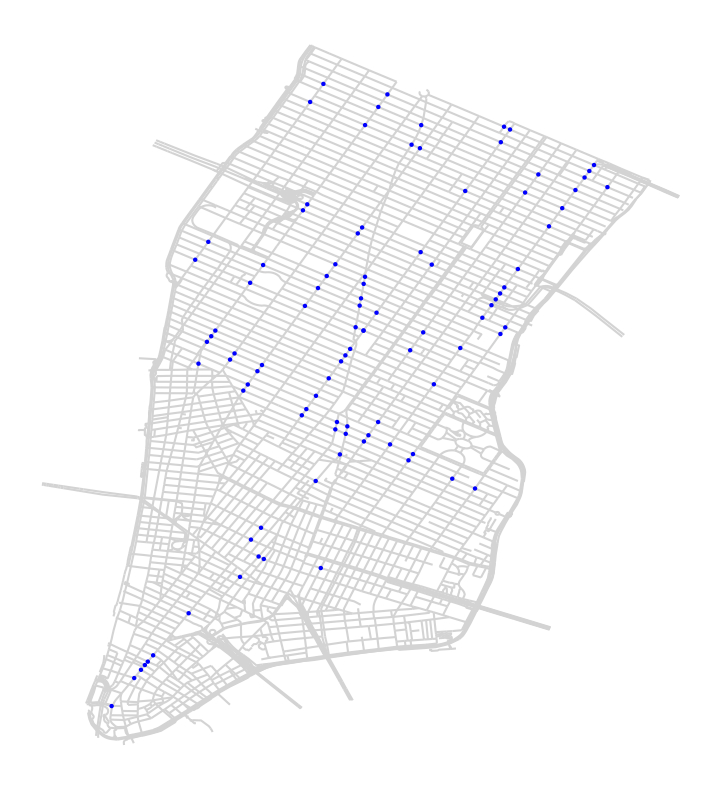

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))

base_map.plot(ax=ax, color='lightgray', edgecolor='none') 
intersections.plot(ax=ax, color='blue', edgecolor='none', markersize = 10, zorder = 2)
plt.axis('off')

### Find all unique instances where a recorded exchange of volume between 2 streets in OTMD corresponds to a geometric intersection between two streets in basemap.geojson. Recorded the streets and the intersection coordinates:

In [49]:
def find_intersections2(base_map, OTMD_data):
    """
    Find intersections of street geometries and associate them with OTMD traffic flow, accounting for
    directions and multiple rows per street based on 'toSt' and 'fromSt'.
    
    :param base_map: GeoDataFrame containing street geometries and names
    :param OTMD_data: DataFrame containing OTMD traffic data with 'toSt', 'fromSt', and 'Direction' columns
    :return: GeoDataFrame containing intersections with associated street directions and traffic flow data
    """
    intersections_list = []
    
    unique_streets = base_map['st_name'].unique()
    
    counter = 0
    
    # Loop over street pairs in base_map
    for i in range(len(unique_streets)):
        
        street1 = unique_streets[i]
        street1_map = base_map[base_map['st_name'] == street1]

        for j in range(i + 1, len(unique_streets)):  # Start at i+1 to avoid self-comparison
            street2 = unique_streets[j]
            street2_map = base_map[base_map['st_name'] == street2]

            # Find intersection between two street geometries
            intersection = street1_map['geometry'].union_all().intersection(street2_map['geometry'].union_all())

            if not intersection.is_empty and isinstance(intersection, Point):

                # Reduce repetitions by not checking date by date but just checking for an instance of an intersection

                # Filter OTMD data for both streets and check if they connect via 'toSt' and 'fromSt'
                street1_to = OTMD_data[OTMD_data['street'] == street1]['toSt'].unique()
                street2_to = OTMD_data[OTMD_data['street'] == street2]['toSt'].unique()
                
                street1_from = OTMD_data[OTMD_data['street'] == street1]['fromSt'].unique()
                street2_from = OTMD_data[OTMD_data['street'] == street2]['fromSt'].unique()

                if street1 in street2_to or street2 in street1_to:

                    street1_data = OTMD_data[OTMD_data['street'] == street1]
                    street2_data = OTMD_data[OTMD_data['street'] == street2]

                    found_intersection = False

                    for _, row1 in street1_data.iterrows():
                        for _, row2 in street2_data.iterrows():
                            if row1['toSt'] == street2 or row2['toSt'] == street1:

                                # Add the intersection along with the street directions and flow information
                                intersections_list.append({
                                    'street1': street1,
                                    'SegmentID1': row1['SegmentID'],
                                    's1_dir': row1['Direction'],
                                    's1_from': row1['fromSt'],
                                    's1_to': row1['toSt'],
                                    'street2': street2,
                                    'SegmentID2': row2['SegmentID'],
                                    's2_dir': row2['Direction'],
                                    's2_from': row2['fromSt'],
                                    's2_to': row2['toSt'],
                                    'marker': intersection
                                })

                                found_intersection = True
                                counter += 1
                                print('intersection added ' + str(counter))
                                break

                        if found_intersection:
                            break  # Exits the second loop as well
                            
                elif street1 in street2_from or street2 in street1_from:

                    street1_data = OTMD_data[OTMD_data['street'] == street1]
                    street2_data = OTMD_data[OTMD_data['street'] == street2]

                    found_intersection = False

                    for _, row1 in street1_data.iterrows():
                        for _, row2 in street2_data.iterrows():
                            if row1['fromSt'] == street2 or row2['fromSt'] == street1:

                                # Add the intersection along with the street directions and flow information
                                intersections_list.append({
                                    'street1': street1,
                                    'SegmentID1': row1['SegmentID'],
                                    's1_dir': row1['Direction'],
                                    's1_from': row1['fromSt'],
                                    's1_to': row1['toSt'],
                                    'street2': street2,
                                    'SegmentID2': row2['SegmentID'],
                                    's2_dir': row2['Direction'],
                                    's2_from': row2['fromSt'],
                                    's2_to': row2['toSt'],
                                    'marker': intersection
                                })

                                found_intersection = True
                                counter += 1
                                print('intersection added ' + str(counter))
                                break

                        if found_intersection:
                            break  # Exits the second loop as well
    
    # Convert to GeoDataFrame
    intersections_gdf = gpd.GeoDataFrame(intersections_list, geometry='marker')
    
    return intersections_gdf

In [50]:
intersections2 = find_intersections2(base_map, OTMD)

intersection added 1
intersection added 2
intersection added 3
intersection added 4
intersection added 5
intersection added 6
intersection added 7
intersection added 8
intersection added 9
intersection added 10
intersection added 11
intersection added 12
intersection added 13
intersection added 14
intersection added 15
intersection added 16
intersection added 17
intersection added 18
intersection added 19
intersection added 20
intersection added 21
intersection added 22
intersection added 23
intersection added 24
intersection added 25
intersection added 26
intersection added 27
intersection added 28
intersection added 29
intersection added 30
intersection added 31
intersection added 32
intersection added 33
intersection added 34
intersection added 35
intersection added 36
intersection added 37
intersection added 38
intersection added 39
intersection added 40
intersection added 41
intersection added 42
intersection added 43
intersection added 44
intersection added 45
intersection added 

(-74.02481678270262, -73.9521620667183, 40.696890087749956, 40.776660772433296)

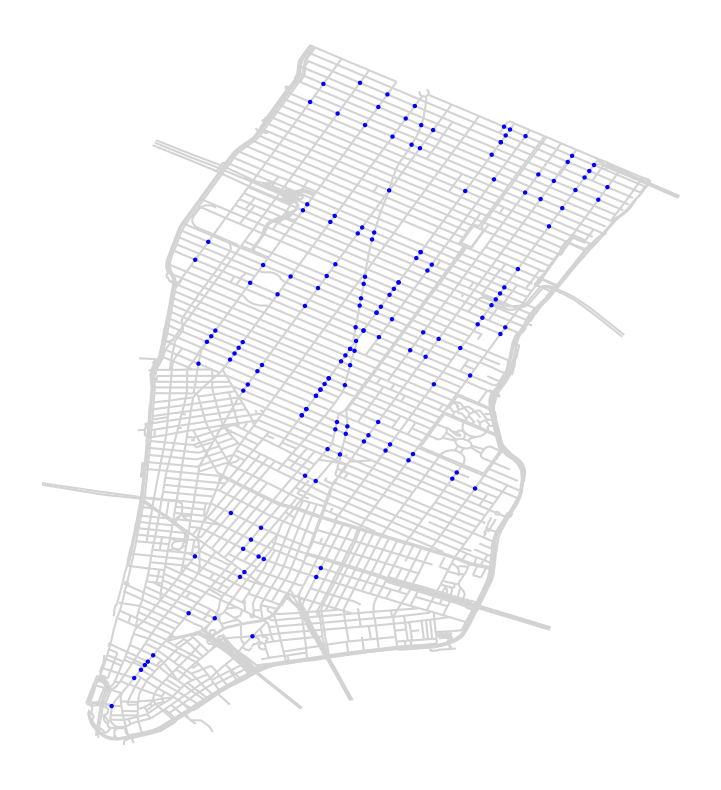

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))

base_map.plot(ax=ax, color='lightgray', edgecolor='none') 
intersections2.plot(ax=ax, color='blue', edgecolor='none', markersize = 10, zorder = 2)
plt.axis('off')

In [62]:
intersectionsOTMD = OTMD[(OTMD['SegmentID'].isin(intersections2['SegmentID1'])) | (OTMD['SegmentID'].isin(intersections2['SegmentID2']))].copy()

intersectionsOTMD

,RequestID,Boro,year,month,day,hour,minute,Vol,SegmentID,WktGeom,street,fromSt,toSt,Direction,datetime,max_volume,congestion
0,24511.0,Manhattan,2016,10,1,0,0,96.0,32074.0,POINT (983870.5633736618 200686.54281152),LAFAYETTE STREET,LEXINGTON AVENUE LINE,LEXINGTON AVENUE LINE,SB,2016-10-01 00:00:00,356.0,0.269663
1,24511.0,Manhattan,2016,10,1,0,0,92.0,32332.0,POINT (984386.5742381364 201430.53428025846),LAFAYETTE STREET,HOWARD STREET,GRAND STREET,SB,2016-10-01 00:00:00,356.0,0.258427
2,24511.0,Manhattan,2016,10,1,0,0,69.0,32337.0,POINT (984550.578402321 201338.51811265876),CENTRE STREET,HOWARD STREET,GRAND STREET,NB,2016-10-01 00:00:00,227.0,0.303965
6,24511.0,Manhattan,2016,10,1,0,15,74.0,32337.0,POINT (984550.578402321 201338.51811265876),CENTRE STREET,HOWARD STREET,GRAND STREET,NB,2016-10-01 00:15:00,227.0,0.325991
7,24511.0,Manhattan,2016,10,1,0,15,84.0,32074.0,POINT (983870.5633736618 200686.54281152),LAFAYETTE STREET,LEXINGTON AVENUE LINE,LEXINGTON AVENUE LINE,SB,2016-10-01 00:15:00,356.0,0.235955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714594,29023.0,Manhattan,2018,10,12,21,30,309.0,36274.0,POINT (993699.4473096249 217079.667644479),3 AVENUE,ASTORIA LINE,EAST 61 STREET,NB,2018-10-12 21:30:00,677.0,0.456425
714597,29023.0,Manhattan,2018,10,12,21,45,325.0,36274.0,POINT (993699.4473096249 217079.667644479),3 AVENUE,ASTORIA LINE,EAST 61 STREET,NB,2018-10-12 21:45:00,677.0,0.480059
714598,29023.0,Manhattan,2018,10,12,21,45,331.0,36277.0,POINT (993256.5919971104 217326.2794700091),LEXINGTON AVENUE,EAST 61 STREET,ASTORIA LINE,SB,2018-10-12 21:45:00,486.0,0.681070
714599,29023.0,Manhattan,2018,10,12,22,0,339.0,36277.0,POINT (993256.5919971104 217326.2794700091),LEXINGTON AVENUE,EAST 61 STREET,ASTORIA LINE,SB,2018-10-12 22:00:00,486.0,0.697531


In [56]:
intersections2['intersection_id'] = intersections2['SegmentID1'].astype(str) + '-' + intersections2['SegmentID2'].astype(str)

### Identify the direction of traffic flow between intersections using toSt and fromSt values, and assign the labels lose_street or gain_street respectively:

In [86]:
def assign_traffic_flow(intersections_df):
    """
    Add 'gain_street' and 'lose_street' columns to the DataFrame based on the s1_to, s1_from, s2_to, and s2_from columns.
    
    :param intersections_df: DataFrame containing traffic intersections with s1_to, s1_from, s2_to, and s2_from columns.
    :return: DataFrame with new columns 'gain_street' and 'lose_street' indicating traffic flow.
    """
    
    # Initialize the new columns
    intersections_df['gain_street'] = None
    intersections_df['lose_street'] = None
    
    # Iterate over each row to determine gain_street and lose_street
    for i, row in intersections_df.iterrows():
        # Check if street1 is receiving traffic (s1_to is not null and s2_from matches s1_to)
        if row['s1_to'] == row['street2']:
            intersections_df.loc[i, 'gain_street'] = row['street2']
            intersections_df.loc[i, 'lose_street'] = row['street1']
        
        # Check if street2 is receiving traffic (s2_to is not null and s1_from matches s2_to)
        elif row['s2_to'] == row['street1']:
            intersections_df.loc[i, 'gain_street'] = row['street1']
            intersections_df.loc[i, 'lose_street'] = row['street2']
        
        # Add more logic if necessary to handle special cases or more nuanced situations

    return intersections_df


In [87]:
intersections3 = assign_traffic_flow(intersections2)

In [88]:
intersections3

,street1,SegmentID1,s1_dir,s1_from,s1_to,street2,SegmentID2,s2_dir,s2_from,s2_to,marker,intersection_id,gain_street,lose_street
0,BATTERY PLACE,235595.0,EB,DEAD END,DEAD END,STATE STREET,22995.0,SB,BRIDGE STREET,BATTERY PLACE,POINT (-74.01429 40.70455),235595.0-22995.0,BATTERY PLACE,STATE STREET
1,RECTOR STREET,23093.0,EB,BROADWAY LINE,BROADWAY,BROADWAY,158808.0,NB,WEST 60 STREET,WEST 61 STREET,POINT (-74.01195 40.70745),23093.0-158808.0,BROADWAY,RECTOR STREET
2,11 AVENUE,33413.0,SB,WEST 28 STREET,WEST 29 STREET,WEST 29 STREET,33891.0,WB,5 AVENUE,BROADWAY,POINT (-74.00427 40.75264),33413.0-33891.0,WEST 29 STREET,11 AVENUE
3,11 AVENUE,33413.0,SB,WEST 28 STREET,WEST 29 STREET,WEST 55 STREET,9003378.0,WB,DEAD END,11 AVENUE,POINT (-73.99235 40.769),33413.0-9003378.0,11 AVENUE,WEST 55 STREET
4,11 AVENUE,33413.0,SB,WEST 28 STREET,WEST 29 STREET,WEST 52 STREET,164736.0,EB,12 AVENUE,11 AVENUE,POINT (-73.99372 40.76713),33413.0-164736.0,11 AVENUE,WEST 52 STREET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,EAST 4 STREET,32585.0,EB,BROADWAY,LAFAYETTE STREET,LAFAYETTE STREET,32074.0,SB,LEXINGTON AVENUE LINE,LEXINGTON AVENUE LINE,POINT (-73.99315 40.72787),32585.0-32074.0,LAFAYETTE STREET,EAST 4 STREET
158,EAST 12 STREET,32789.0,EB,BROADWAY,4 AVENUE,4 AVENUE,32775.0,NB,EAST 9 STREET,EAST 10 STREET,POINT (-73.99003 40.73275),32789.0-32775.0,4 AVENUE,EAST 12 STREET
159,4 AVENUE,32775.0,NB,EAST 9 STREET,EAST 10 STREET,EAST 13 STREET,32942.0,WB,3 AVENUE,4 AVENUE,POINT (-73.98987 40.73353),32775.0-32942.0,4 AVENUE,EAST 13 STREET
160,MADISON STREET,9006437.0,WB,DEAD END,DEAD END,ST JAMES PLACE,23752.0,NB,MADISON STREET,JAMES STREET,POINT (-73.9997 40.71178),9006437.0-23752.0,None,None


## The following process builds on the output of assign_traffic_flow, in this case intersections3, to correspond identified intersections to their relevant datetimes and volume exchanges in OTMD

## The result, traffic_intersections keeps track of volume exchanges per intersection per datetime. Stores marker coordinates as well as information on the traffic volume moving towards and away from each intersection, to which streets:

In [150]:
# Initialize the new DataFrame with the correct columns
new_columns = ['datetime', 'to_vol', 'from_vol', 'total_vol'] + list(intersections3.columns)

rows_list = []


intersectionDates = intersectionsOTMD['datetime'].unique()

for datetime in intersectionDates:
    

    time_slice = OTMD[OTMD['datetime'] == datetime]
    

    for i, row in intersections3.iterrows():
        

        gain_slice = time_slice[(time_slice['street'] == row['gain_street']) & (time_slice['fromSt'] == row['lose_street'])]
        lose_slice = time_slice[(time_slice['street'] == row['lose_street']) & (time_slice['toSt'] == row['gain_street'])]
        
        # Calculate the volume coming into and leaving the intersection
        to_vol = gain_slice['Vol'].sum()
        from_vol = lose_slice['Vol'].sum()
        
        if to_vol != 0 or from_vol != 0:
        

            total_vol = to_vol - from_vol


            new_row = {
                'datetime': datetime,
                'to_vol': to_vol,
                'from_vol': from_vol,
                'total_vol': total_vol,
                'street1' : row['street1'],
                'SegmentID1' : row['SegmentID1'],
                's1_dir' : row['s1_dir'],
                's1_from': row['s1_from'],
                's1_to' : row['s1_to'],
                'street2': row['street2'],
                'SegmentID2': row['SegmentID2'],
                's2_dir': row['s2_dir'],
                's2_from' : row['s2_from'],
                's2_to' : row['s2_to'],
                'marker' : row['marker'],
                'intersection_id' : row['intersection_id'],
                'gain_street' : row['gain_street'], 
                'lose_street' : row['lose_street']}
        
        
            rows_list.append(new_row)
  
traffic_intersections = pd.DataFrame(rows_list)

In [151]:
traffic_intersections_dates = traffic_intersections['datetime'].unique()

In [165]:
print(pos_vol.max())
print(pos_vol.min())

print(neg_vol.max())
print(neg_vol.min())

967.0
1.0
-1.0
-1007.0


### For a given datetime, plots intersection markers where there is a recorded exchange of volume beteween two streets at the given datetetime.

### An example use of the data stored in traffic_intersections

In [206]:
pos_vol = traffic_intersections[traffic_intersections['total_vol'] > 0]['total_vol']
neg_vol = traffic_intersections[traffic_intersections['total_vol'] < 0]['total_vol']

pos_max = pos_vol.max()
neg_max = abs(neg_vol.min())

norm_pos = plt.Normalize(vmin=1, vmax=pos_max)
norm_neg = plt.Normalize(vmin=1, vmax=neg_max)


def intersection_map(datetime):
    cmap_pos = plt.cm.get_cmap('spring')  # Red to green color map, reversed (positive)
    cmap_neg = plt.cm.get_cmap('winter')  # Cool to warm color map for negative value

    # Filter data for the specific datetime
    datetime_data = traffic_intersections[traffic_intersections['datetime'] == datetime]

    # Create a new figure
    fig, ax = plt.subplots()

    base_map.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)

    # Iterate over each street segment
    for _, row in datetime_data.iterrows():
        
        if pd.notna(row['marker']):
            if row['total_vol'] > 0:
                # Apply log scaling to positive total_vol
                normalized_vol = row['total_vol']
                color = cmap_pos(norm_pos(normalized_vol))
            elif row['total_vol'] < 0:
                # Apply log scaling to negative total_vol
                normalized_vol = abs(row['total_vol'])
                color = cmap_neg(norm_neg(normalized_vol))
            else:
                # In case of zero total_vol, use a neutral color (gray)
                color = 'gray'
            
            ax.scatter(row['marker'].x, row['marker'].y, color=color, s=2, zorder=2)
            

        
    ax.set_title(f'{datetime}')
    plt.axis('off')

    ## Save the figure as an image
    #output_file = os.path.join(f'{index:04d}_{datetime}.png')
    #output_path = f'{output_dir}/{output_file}'
    #plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    #return(output_file)

/var/folders/js/by2fcrxd7xs7tqhrrq5xncgw0000gn/T/ipykernel_66678/1802702299.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_pos = plt.cm.get_cmap('spring')  # Red to green color map, reversed (positive)
/var/folders/js/by2fcrxd7xs7tqhrrq5xncgw0000gn/T/ipykernel_66678/1802702299.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_neg = plt.cm.get_cmap('winter')  # Cool to warm color map for negative value


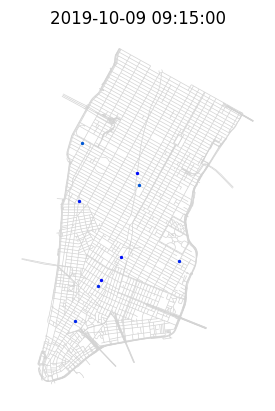

In [363]:
test_date = traffic_intersections_dates[4000]

intersection_map(test_date)

### Sort traffic_intersections to get traffic_intersection_dates, which will be a key source of data for the following notebook, 09_Directional_Traffic_Flow_Map, where this data will be animated.

In [212]:
sorted_intersection_dates = traffic_intersections.sort_values(by=['datetime', 'gain_street', 'lose_street'])
sorted_intersection_dates

,datetime,to_vol,from_vol,total_vol,street1,SegmentID1,s1_dir,s1_from,s1_to,street2,SegmentID2,s2_dir,s2_from,s2_to,marker,intersection_id,gain_street,lose_street
0,2016-10-01 00:00:00,0.0,69.0,-69.0,CENTRE STREET,32337.0,NB,HOWARD STREET,GRAND STREET,GRAND STREET,32327.0,EB,BROADWAY,CROSBY STREET,POINT (-73.9985232734708 40.719785146159396),32337.0-32327.0,GRAND STREET,CENTRE STREET
1,2016-10-01 00:00:00,0.0,92.0,-92.0,GRAND STREET,32327.0,EB,BROADWAY,CROSBY STREET,LAFAYETTE STREET,32332.0,SB,HOWARD STREET,GRAND STREET,POINT (-73.99906145014921 40.72004430035703),32327.0-32332.0,GRAND STREET,LAFAYETTE STREET
2,2016-10-01 00:15:00,0.0,74.0,-74.0,CENTRE STREET,32337.0,NB,HOWARD STREET,GRAND STREET,GRAND STREET,32327.0,EB,BROADWAY,CROSBY STREET,POINT (-73.9985232734708 40.719785146159396),32337.0-32327.0,GRAND STREET,CENTRE STREET
3,2016-10-01 00:15:00,0.0,81.0,-81.0,GRAND STREET,32327.0,EB,BROADWAY,CROSBY STREET,LAFAYETTE STREET,32332.0,SB,HOWARD STREET,GRAND STREET,POINT (-73.99906145014921 40.72004430035703),32327.0-32332.0,GRAND STREET,LAFAYETTE STREET
4,2016-10-01 00:30:00,0.0,77.0,-77.0,CENTRE STREET,32337.0,NB,HOWARD STREET,GRAND STREET,GRAND STREET,32327.0,EB,BROADWAY,CROSBY STREET,POINT (-73.9985232734708 40.719785146159396),32337.0-32327.0,GRAND STREET,CENTRE STREET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96362,2019-10-31 04:00:00,0.0,10.0,-10.0,WEST 18 STREET,32463.0,EB,8 AVENUE,9 AVENUE,9 AVENUE,33699.0,SB,WEST 40 STREET,WEST 39 STREET,POINT (-74.00354201925023 40.74344827908281),32463.0-33699.0,9 AVENUE,WEST 18 STREET
96363,2019-10-31 04:00:00,0.0,72.0,-72.0,5 AVENUE,32813.0,SB,EAST 17 STREET,EAST 18 STREET,EAST 18 STREET,164329.0,EB,BROADWAY,PARK AVENUE SOUTH,POINT (-73.99179768837975 40.73850365378348),32813.0-164329.0,EAST 18 STREET,5 AVENUE
96364,2019-10-31 04:15:00,0.0,54.0,-54.0,5 AVENUE,32813.0,SB,EAST 17 STREET,EAST 18 STREET,EAST 18 STREET,164329.0,EB,BROADWAY,PARK AVENUE SOUTH,POINT (-73.99179768837975 40.73850365378348),32813.0-164329.0,EAST 18 STREET,5 AVENUE
96365,2019-10-31 04:30:00,0.0,50.0,-50.0,5 AVENUE,32813.0,SB,EAST 17 STREET,EAST 18 STREET,EAST 18 STREET,164329.0,EB,BROADWAY,PARK AVENUE SOUTH,POINT (-73.99179768837975 40.73850365378348),32813.0-164329.0,EAST 18 STREET,5 AVENUE


### Identifies and creates an index of all geometric intersections between streets in basemap.geojson. Stores marker coordinates, street1, and street2

### Currently unutilized

In [616]:
def create_intersection_index(base_map):
    """
    Create an index of all intersections in the base map, storing the point marker and the street names
    of every intersection.
    
    :param base_map: GeoDataFrame containing the street geometries
    :return: Dictionary with intersections as keys and list of intersecting streets as values
    """
    intersection_index = {}

    # Loop through each street and compare it with others to find intersections
    for idx1, street1_row in base_map.iterrows():
        for idx2, street2_row in base_map.iterrows():
            if idx1 == idx2:
                continue  # Skip same street

            # Check if the geometries of the two streets intersect
            if street1_row['geometry'].intersects(street2_row['geometry']):
                intersection_point = street1_row['geometry'].intersection(street2_row['geometry'])

                # If the intersection is a point, store it with the street names
                if intersection_point.geom_type == 'Point':
                    intersection_key = (intersection_point.x, intersection_point.y)

                    if intersection_key not in intersection_index:
                        intersection_index[intersection_key] = []

                    # Add the street names to the intersection
                    intersection_index[intersection_key].append((street1_row['st_name'], street2_row['st_name']))

    return intersection_index


In [617]:
inix = create_intersection_index(base_map)

## Save Data!

In [810]:
import json

In [812]:
inix_str_keys = {str(key): value for key, value in inix.items()}

with open('inix.json', 'w') as json_file:
    json.dump(inix_str_keys, json_file)
    
    


In [813]:
sorted_intersection_dates.to_csv('sorted_intersection_dates.csv', index = False)